# GEOG 288CJ Homework-04

## Ian Baxter

In [2]:
import numpy as np
from numba import jit
import pandas as pd

****1)	For the dataset provided in Gaucho Space, calculate the following quantities:***

***a)	The means and standard deviations of u, v, w and T***

***b)	The mean “cup” speed. How does this speed compare with the cup speed estimated using the expression on page 31 of the ABL notes?***

***c)	The skewnesses of u, v, w and T***

***Important: suppose that you are “online”, that is, your computer code should provide statistics on the fly after 30-min. In other words, do not compute the means first and then read the data again, subtracting off the means to compute variances. Include your computed code with your answers***


## 1) Means and standard deviations 

In [3]:
names = ['year','month','day','hour','minutes','seconds','u','v','w','T']
df = pd.read_excel('homework-04.xlsx',skiprows=np.arange(0,8,step=1),names=names)
df.head()

,year,month,day,hour,minutes,seconds,u,v,w,T
0,2008,6,21,12,0,0.0,4.75675,1.39575,2.27300,25.0815
1,2008,6,21,12,0,0.1,4.65325,1.24525,1.99725,25.3056
2,2008,6,21,12,0,0.2,4.58150,1.17250,2.05800,25.2142
3,2008,6,21,12,0,0.3,3.84200,1.60775,2.11575,25.0919
4,2008,6,21,12,0,0.4,4.08350,1.56525,1.88725,25.0884


\begin{align}
\sigma^{2} = (\frac{\sum{x_{i}^{2}}}{N}) - (\frac{\sum{x_{i}}}{N})^{2}
\end{align}

\begin{align}
Initialize:   M_{1} = x_{1} and S_{1} = 0
\end{align}

\begin{align}
M_{k} = M_{k-1} + (x_{k} - M_{k-1})/k
\end{align}

\begin{align}
S_{k} = S_{k-1} + (x_{k} - M_{k-1})*(x_{k} - M_{k})
\end{align}

\begin{align}
\sigma^{2} = \frac{S_{k}}{k-1}
\end{align}

In [36]:
def read_lbl(k):
    names = ['year','month','day','hour','minutes','seconds','u','v','w','T']
    df = pd.read_excel('homework-04.xlsx',skiprows=np.arange(0,k+8,step=1),names=names,nrows=1.)
    return df

def online_mean_variance(var):
    """adapted from John D. Cook's algorithm"""
    M = np.zeros(30*60*10)
    M[0] = df[var][0]
    S = np.zeros(30*60*10)
    for k in range(1,30*60*10):
        M[k] = M[k-1] + (df[var][k] - M[k-1])/k
        S[k] = S[k-1] + (df[var][k] - M[k-1]) * (df[var][k] - M[k])
    s2 =  S/(k-1)
    return M[-1], np.sqrt(s2[-1])

def init(outstep):
    M_out = np.zeros(30./outstep)
    S_out = np.zeros(30./outstep)
    M = np.zeros(30*60*10)
    S = np.zeros(30*60*10)
    return M,S,M_out,S_out

#@jit
def online_mean_variance(var, outstep=30):
    """adapted from John D. Cook's algorithm"""
    M,S,M_out,S_out = init(outstep)
    M[0] = read_lbl(0)[var]
    print(M)
    for k in range(1,30*60*10):
        M[k] = M[k-1] + (read_lbl(k)[var] - M[k-1])/k
        S[k] = S[k-1] + (read_lbl(k)[var] - M[k-1]) * (read_lbl(k)[var] - M[k])
        if k == outstep*60*10:
            M_out[outstep] = M[k]
            print(M_out)
            S_out[outstep] = S[k]
            print(S_out)
            M[k] = 0
            S[k] = 0
    s2 =  S/(k-1)
    return M[-1], s2[-1]

vars = ['u','v','w','T']
#out = [online_mean_variance(var) for var in vars]
out = online_mean_variance('u',outstep=1)
print('Mean and standard deviation for all variables calculated using online single-pass algorithm')
out

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
def online_mean(x):
    """adapted from John D. Cook's algorithm"""

    M = np.zeros(len(x))
    M[0] = x[0]
    S = np.zeros(len(x))
    for k in range(1,len(x)):
        M[k] = M[k-1] + (x[k] - M[k-1])/k
        S[k] = S[k-1] + (x[k] - M[k-1]) * (x[k] - M[k])
        if k == 30*60*10:
            
    s2 =  S/(k-1)
    return M[-1]

def online_std(var):
    """adapted from John D. Cook's algorithm based on Welford (1964)"""
    x = df[var]

    M = np.zeros(len(x))
    M[0] = x[0]
    S = np.zeros(len(x))
    for k in range(1,len(x)):
        M[k] = M[k-1] + (x[k] - M[k-1])/k
        S[k] = S[k-1] + (x[k] - M[k-1]) * (x[k] - M[k])

    s2 =  S/(k-1)
    return np.sqrt(s2[-1])

In [ ]:
def online_covariance(data1, data2):
    meanx = meany = C = n = 0
    for x, y in zip(data1, data2):
        n += 1
        dx = x - meanx
        meanx += dx / n
        meany += (y - meany) / n
        C += dx * (y - meany)
    return C / n

In [5]:
import math
class Welford(object):
    """from alexalemi"""
    def __init__(self,lst=None):
        self.k = 0
        self.M = 0
        self.S = 0
        
        self.__call__(lst)
    
    def update(self,x):
        if x is None:
            return
        self.k += 1
        newM = self.M + (x - self.M)*1./self.k
        newS = self.S + (x - self.M)*(x - newM)
        self.M, self.S = newM, newS

    def consume(self,lst):
        lst = iter(lst)
        for x in lst:
            self.update(x)
    
    def __call__(self,x):
        if hasattr(x,"__iter__"):
            self.consume(x)
        else:
            self.update(x)
            
    @property
    def mean(self):
        return self.M
    @property
    def meanfull(self):
        return self.mean, self.std/math.sqrt(self.k)
    @property
    def std(self,):
        if self.k==1:
            return 0
        return math.sqrt(self.S/(self.k-1))
    def __repr__(self):
        return "<Welford: {} +- {}>".format(self.mean, self.std)
    
def get_mean(var):
    std = Welford()
    std(var)
    return std.mean

def get_std(var):
    std = Welford()
    std(df[var])
    return std.std

In [22]:
vars  = ['u','v','w','T']

std = [online_std(var) for var in vars]
std

[1.970589327336093, 1.8642089665121815, 0.9985733131770974, 0.4451846460016456]

## 2) Cup Speed and Approximate Cup Speed

In [60]:
def online_mean_cup_speed(df):
    """adapted from John D. Cook's algorithm"""
    x = np.sqrt(df['u'] * df['u'] + df['v'] * df['v'])
    
    M = np.zeros(len(x))
    M[0] = x[0]
    S = np.zeros(len(x))
    for k in range(1,len(x)):
        M[k] = M[k-1] + (x[k] - M[k-1])/k
        S[k] = S[k-1] + (x[k] - M[k-1]) * (x[k] - M[k])

    s2 =  S/(k-1)
    return M[-1]

def cup_speed(df):
    return np.sqrt(df['u'] * df['u'] + df['v'] * df['v'])

def approx_cup_speed(df):
    u_bar = online_mean(df['u'])
    v_prime = online_covariance(df['v'],df['v'])
    #v_prime = 1.8642089665121815 * 1.8642089665121815
    return u_bar * (1 + v_prime / (2 * u_bar * u_bar))

**Approximate Cup Speed**

\begin{align}
\bar{U} = \bar{u} (1 + \bar{v'^{2}} / 2\bar{u}^{2})
\end{align}

In [70]:
# Using absolute cup speed from ABL notes
U_bar = online_mean_cup_speed(df)
U_bar

5.642070961310037

In [77]:
# Using approximation of cup speed from ABL notes
U = approx_cup_speed(df)
U

5.545109562412604

The two methods in this case give a very similar result. The mean wind speed U_bar is still larger than either of the individual horizontal wind components, which is qualitatively what we would expect to see. However, the approximation seems to underestimate the horizontal wind speed, atleast in this scenario. 

## 3) Skewness

In [72]:
def kp_skewness(df):
    """Karl Pearson's coefficient of skewness"""
    return 3*(np.mean(df) - np.median(df,axis=0))/np.std(df)

def skewness(df):
    return np.sum((df - np.mean(df))**3) / len(df) / np.std(df)**3
 

In [73]:
# Skewness from the notes
sk = skewness(df)
sk

year                NaN
month               NaN
day                 NaN
hour                NaN
minutes    0.000000e+00
seconds    3.011322e-19
u          4.140705e-02
v         -1.788010e-01
w          1.750624e-01
T          2.682892e-01
dtype: float64

In [74]:
# Karl Pearson skewness
sk = kp_skewness(df)
sk

year            NaN
month           NaN
day             NaN
hour            NaN
minutes    0.000000
seconds    0.000000
u          0.087103
v          0.009920
w          0.149474
T          0.123251
dtype: float64

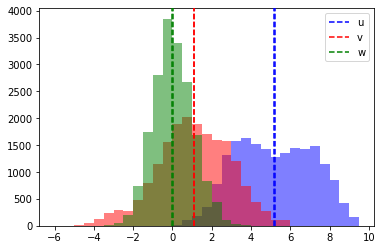

In [75]:
import matplotlib.pyplot as plt

ax = plt.axes()
ax.axvline(np.mean(df['u']),linestyle='--',c='blue',zorder=100)
ax.axvline(np.mean(df['v']),linestyle='--',c='red',zorder=101)
ax.axvline(np.mean(df['w']),linestyle='--',c='green',zorder=102)

ax.axvline(np.median(df['u']),linestyle='--',c='blue',zorder=201)
ax.axvline(np.median(df['v']),linestyle='--',c='red',zorder=202)
ax.axvline(np.median(df['w']),linestyle='--',c='green',zorder=203)

ax.hist(df['u'],bins=np.arange(0,10,step=0.5),color='blue',alpha=0.5)
ax.hist(df['v'],bins=np.arange(-6,6.5,step=0.5),color='red',alpha=0.5)
ax.hist(df['w'],bins=np.arange(-4,4.5,step=0.5),color='green',alpha=0.5)

plt.legend(['u','v','w']);

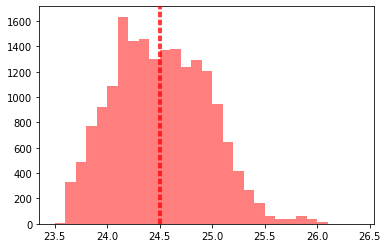

In [76]:
import matplotlib.pyplot as plt

ax = plt.axes()
#ax.axvline(np.mean(df['w']),linestyle='--',c='blue',zorder=100)
ax.axvline(np.mean(df['T']),linestyle='--',c='red',zorder=101)

#ax.axvline(np.median(df['w']),linestyle='--',c='blue',zorder=102)
ax.axvline(np.median(df['T']),linestyle='--',c='red',zorder=103)

#ax.hist(df['w'],bins=np.arange(0,10,step=0.5),color='blue',alpha=0.5)
ax.hist(df['T'],bins=np.arange(23.5,26.5,step=0.1),color='red',alpha=0.5);